In [1]:
import pandas as pd
import numpy as np
import yaml
import os
from matplotlib import pyplot as plt
import pickle
import sys
sys.path.append('../src')

os.environ["CUDA_VISIBLE_DEVICES"]="1"

data_path = 'data'
data_save_path = '/home/schestakov/data/re-identification/porto'

In [7]:
from utils import create_attacked_sets, pkl2h5, read_train_file
data_path = "/data/shared/schestakov/re-identification/preprocessed_data/porto/db_exp2/dl_models"

# For our model we convert into numpy as save as .npz 
max_len = 150
#train_src, train_src_len = read_train_file(os.path.join(data_save_path, "train.src"), max_len)
train_trg, train_trg_len = read_train_file(os.path.join(data_path, "train.trg"), max_len)
#val_src, val_src_len = read_train_file(os.path.join(data_save_path, "val.src"), max_len)
val_trg, val_trg_len = read_train_file(os.path.join(data_path, "val.trg"), max_len)

Importing file: /data/shared/schestakov/re-identification/preprocessed_data/porto/db_exp2/dl_models/train.trg


27276300it [04:37, 98203.81it/s] 


Importing file: /data/shared/schestakov/re-identification/preprocessed_data/porto/db_exp2/dl_models/val.trg


3409540it [00:20, 169655.13it/s]


In [8]:
train_trg_new = [[p for p in t[0] if p != 0] for t in train_trg]
val_trg_new = [[p for p in t[0] if p != 0] for t in val_trg]
train_trg_new.extend(val_trg_new)

# safe pickle train_trg_new
with open(os.path.join(data_path, 're_trace_train.pkl'), "wb") as f:
    pickle.dump(train_trg_new, f)

In [2]:
fp_porto = "/home/schestakov/data/porto/train.csv"
porto_df = pd.read_csv(fp_porto)

In [3]:
# Get the List of Trajectories from Table
traj_list = porto_df['POLYLINE'].tolist()

In [4]:
# Format the Trajectories to Lists of [Lat,Lon] from String
import ast
from tqdm import tqdm
traj_list = [ast.literal_eval(t) for t in tqdm(traj_list)]

100%|██████████| 1710670/1710670 [07:09<00:00, 3984.59it/s]


In [5]:
traj_list

[[[-8.618643, 41.141412],
  [-8.618499, 41.141376],
  [-8.620326, 41.14251],
  [-8.622153, 41.143815],
  [-8.623953, 41.144373],
  [-8.62668, 41.144778],
  [-8.627373, 41.144697],
  [-8.630226, 41.14521],
  [-8.632746, 41.14692],
  [-8.631738, 41.148225],
  [-8.629938, 41.150385],
  [-8.62911, 41.151213],
  [-8.629128, 41.15124],
  [-8.628786, 41.152203],
  [-8.628687, 41.152374],
  [-8.628759, 41.152518],
  [-8.630838, 41.15268],
  [-8.632323, 41.153022],
  [-8.631144, 41.154489],
  [-8.630829, 41.154507],
  [-8.630829, 41.154516],
  [-8.630829, 41.154498],
  [-8.630838, 41.154489]],
 [[-8.639847, 41.159826],
  [-8.640351, 41.159871],
  [-8.642196, 41.160114],
  [-8.644455, 41.160492],
  [-8.646921, 41.160951],
  [-8.649999, 41.161491],
  [-8.653167, 41.162031],
  [-8.656434, 41.16258],
  [-8.660178, 41.163192],
  [-8.663112, 41.163687],
  [-8.666235, 41.1642],
  [-8.669169, 41.164704],
  [-8.670852, 41.165136],
  [-8.670942, 41.166576],
  [-8.66961, 41.167962],
  [-8.668098, 41.16898

In [9]:
len(traj_list)

1704769

In [15]:
count = sum(1 for x in traj_list if x == [])
print(count)
traj_list = [ele for ele in traj_list if ele != []]
count = sum(1 for x in traj_list if x == [])
print(count)

0
0


In [18]:
# Add time dim
traj_list_t = []
for traj in tqdm(traj_list):
    traj_new = []
    t = 0
    for x,y in traj:
        traj_new.append([x,y,t])
        t = t + 15
    traj_list_t.append(traj_new)

100%|██████████| 1704769/1704769 [01:25<00:00, 19980.25it/s]


In [8]:
# Remove empty trajs
traj_list = [ele for ele in traj_list if ele != []]
len(traj_list)

1704769

In [10]:
with open(os.path.join(data_save_path , "traj_list.pkl"), 'wb') as handle:
    pickle.dump(traj_list_t, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Try interpolation

In [17]:
traj

array([], dtype=float64)

In [19]:
time_delta = 15
from scipy import interpolate
# Interpolate trajectories to hjave 15secs intervalls
traj_list_i = []
for traj in tqdm(traj_list_t):
    traj = np.array(traj)
    if traj[-1,2] <= time_delta*2:
        continue    

    x = traj[:,0]
    y = traj[:,1]
    t = traj[:,2]

    ticks = int(t[-1]/time_delta) # 15 sec intervalls

    # Interpolate
    tck,u=interpolate.splprep([x,y,t],s=0.0)
    x_i, y_i, t_i= interpolate.splev(np.linspace(0,1,ticks),tck)

    t_new =  np.vstack((y_i, x_i, t_i.astype(int))).T
    traj_list_i.append(t_new.tolist())

100%|██████████| 1704769/1704769 [03:31<00:00, 8054.97it/s] 


In [ ]:
#Some how we get less traces after interpolation

In [43]:
idx = 100

t_i = traj_list_t[idx]
t_i = [[x,y] for x,y,t in t_i]

t = traj_list_t[idx]
t = [[y,x] for x,y,t in t]

In [51]:
len(traj_list_i)

1662144

In [45]:
t_i

[[41.15297700000001, -8.660232],
 [41.15384716151452, -8.662259330334853],
 [41.156988445135376, -8.664290957356307],
 [41.15869214840689, -8.664106371188824],
 [41.16023584000745, -8.659708758609975],
 [41.16190537981949, -8.655935846724372],
 [41.162215249782534, -8.655554410828424],
 [41.161980740112156, -8.654112385164277],
 [41.16118147861113, -8.64924364144086],
 [41.1603389520556, -8.644794261097442],
 [41.16014773392476, -8.643959324492705],
 [41.16000111111024, -8.64289822663619],
 [41.16000072833768, -8.642389544199245],
 [41.16004156697919, -8.642517610305763],
 [41.15976686114773, -8.641100559146292],
 [41.159382668785085, -8.637752295784882],
 [41.158178650695206, -8.63696730638921],
 [41.157753808072414, -8.635834069067533],
 [41.158863, -8.635536]]

In [46]:
import trace_plotting
trace_plotting.plot_two_traces(t_i, t)

In [ ]:
#with open(os.path.join(data_save_path , "traj_list_interp.pkl"), 'wb') as handle:
#    pickle.dump(traj_list_i, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Histogramm of trajectory lengths

In [7]:
traj_length = [len(t) for t in traj_list]

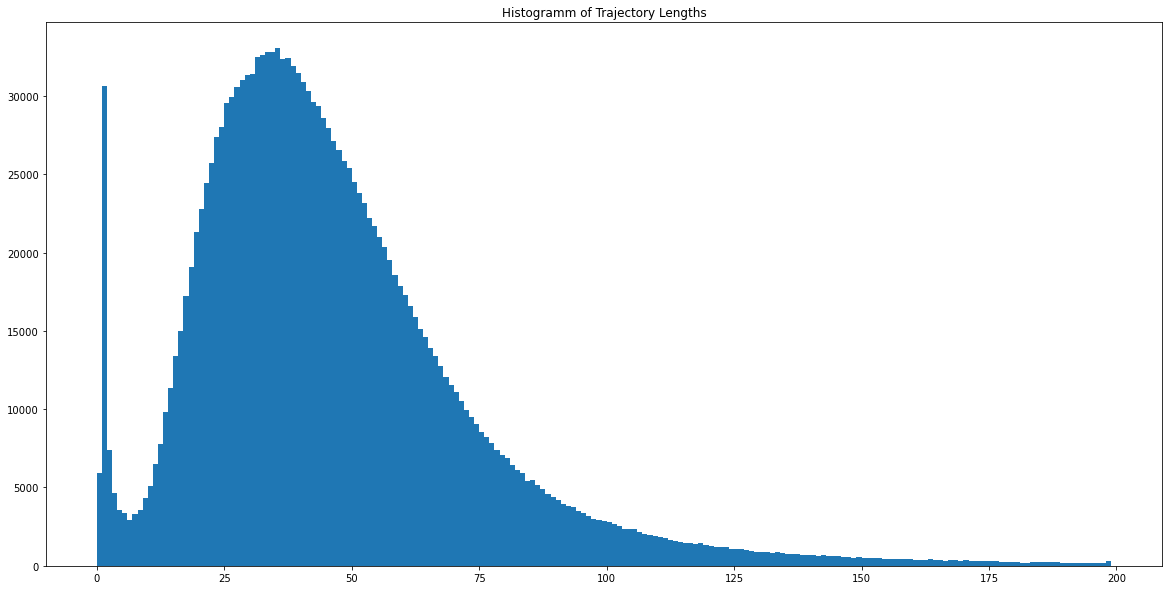

In [20]:


bins = np.arange(0, 200, 1) # fixed bin size
counts, bins, _ = plt.hist(traj_length, bins=bins)
plt.title('Histogramm of Trajectory Lengths')

plt.rcParams["figure.figsize"] = (20,10)
plt.show()

If filtered for trajectory length between 10 and 150 we get around 1.6 Million Trajectories

In [40]:
traj_length_filtered = [x for x in traj_length if x>10 and x<150]

In [41]:
len(traj_length_filtered)

1605641

In [52]:
traj_list = [t for t in traj_list if 10 <= len(t) <= 150]
traj_list_t = [t for t in traj_list_t if 10 <= len(t) <= 150]
traj_list_i = [t for t in traj_list_i if 10 <= len(t) <= 150]

In [56]:
with open(os.path.join(data_save_path , "traj_list_interp.pkl"), 'wb') as handle:
    pickle.dump(traj_list_i, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [57]:
with open(os.path.join(data_save_path , "traj_list.pkl"), 'wb') as handle:
    pickle.dump(traj_list_t, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [58]:
with open(os.path.join(data_save_path , "traj_list_notime.pkl"), 'wb') as handle:
    pickle.dump(traj_list, handle, protocol=pickle.HIGHEST_PROTOCOL)